In [1]:
import pandas as pd
import numpy as np
import os
import sys

# !pip install librosa
# !pip install lifelines
# !pip install np_utils
# !pip install tensorflow

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt


import sklearn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

## Importing and Splitting the datasets

In [2]:
#importing the datasets
train_set = pd.read_csv('./outputs/train_set_ov2.csv')
test_set = pd.read_csv('./outputs/test_set_ov2.csv')

In [3]:
#Split into features and target; x = features, y = target
x_train = train_set.iloc[:, 1:]
y_train = train_set['label']

x_test = test_set.iloc[:, 1:]
y_test = test_set['label']

#combining test and train set for cross validation
x = pd.concat([x_train, x_test])
y = pd.concat([y_train, y_test])

In [4]:
x_test

,lm_1_x,lm_1_y,lm_1_z,lm_2_x,lm_2_y,lm_2_z,lm_3_x,lm_3_y,lm_3_z,lm_4_x,...,lm_475_z,lm_476_x,lm_476_y,lm_476_z,lm_477_x,lm_477_y,lm_477_z,lm_478_x,lm_478_y,lm_478_z
0,0.506702,0.746145,-0.052472,0.514746,0.638546,-0.127808,0.511097,0.660831,-0.061017,0.491482,...,0.009648,0.642590,0.412839,0.009652,0.617289,0.435031,0.009619,0.642846,0.458015,0.009624
1,0.473390,0.674256,-0.083987,0.458269,0.603338,-0.139770,0.468669,0.630927,-0.084655,0.449013,...,0.016601,0.625927,0.450008,0.016597,0.602415,0.468034,0.016574,0.623425,0.487518,0.016578
2,0.475091,0.712748,-0.064066,0.461303,0.598940,-0.138101,0.474313,0.626583,-0.068561,0.447728,...,-0.030456,0.632130,0.402564,-0.030461,0.604959,0.423050,-0.030489,0.628164,0.448405,-0.030485
3,0.493484,0.664245,-0.059163,0.471933,0.590218,-0.162500,0.486533,0.611204,-0.076221,0.453270,...,0.002333,0.679121,0.346882,0.002329,0.642678,0.380518,0.002300,0.680462,0.413192,0.002304
4,0.523146,0.650589,-0.062593,0.519441,0.581467,-0.126982,0.518384,0.603058,-0.068003,0.493491,...,0.010894,0.615893,0.410073,0.010895,0.592702,0.431683,0.010865,0.617758,0.450027,0.010870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2710,0.510256,0.683243,-0.070947,0.516699,0.595183,-0.144286,0.514165,0.620626,-0.072752,0.490072,...,0.015552,0.642479,0.379912,0.015555,0.614993,0.404506,0.015520,0.643303,0.428452,0.015526
2711,0.505334,0.686409,-0.058882,0.508532,0.599290,-0.122200,0.509442,0.622162,-0.062568,0.491475,...,0.011714,0.641445,0.401308,0.011715,0.616812,0.420869,0.011687,0.638138,0.443780,0.011692
2712,0.478502,0.704455,-0.054058,0.466725,0.630798,-0.111903,0.480140,0.650520,-0.051867,0.451859,...,-0.000233,0.622744,0.435086,-0.000233,0.593390,0.463393,-0.000256,0.623990,0.490850,-0.000254
2713,0.535946,0.839739,-0.009758,0.533225,0.735975,-0.171670,0.536654,0.754226,-0.058587,0.508789,...,-0.075247,0.767251,0.377080,-0.075249,0.724138,0.410647,-0.075284,0.763825,0.447404,-0.075284


In [5]:
import sklearn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

#Get the labels
encoder = OneHotEncoder()
y_train = encoder.fit_transform(np.array(y_train).reshape(-1,1)).toarray()
y_test = encoder.fit_transform(np.array(y_test).reshape(-1,1)).toarray()

y_test

array([[0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]])

In [6]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
# x_train.shape, y_train.shape, x_test.shape, y_test.shape

x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
# x_train.shape, y_train.shape, x_test.shape, y_test.shape

In [7]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((10861, 1434, 1), (10861, 4), (2715, 1434, 1), (2715, 4))

In [8]:
model= Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=4, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1434, 256)         1536      
                                                                 
 max_pooling1d (MaxPooling1  (None, 717, 256)          0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 717, 256)          327936    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 359, 256)          0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 359, 256)          327936    
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 180, 256)        

In [9]:
checkpoint_filepath = os.getcwd() + '/ckpt_cnn/Epoch{epoch:02d}_{val_accuracy:.2f}.keras'
checkpoint_filepath

'C:\\Users\\Aaron\\Desktop\\Github Projects\\AFFECT\\AFFECTV-XX22-Project-revised-oversampling/ckpt_cnn/Epoch{epoch:02d}_{val_accuracy:.2f}.keras'

In [10]:
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max')

In [11]:
rlrp = ReduceLROnPlateau(monitor='val_accuracy', factor=0.8, verbose=1, patience=2, min_lr=0.0001)
history = model.fit(x_train, y_train, batch_size=64, epochs=30, validation_data=(x_test, y_test), callbacks=[rlrp, model_checkpoint_callback])

Epoch 1/30


170/170 [==============================] - 76s 441ms/step - loss: 1.2346 - accuracy: 0.4344 - val_loss: 0.9503 - val_accuracy: 0.6866 - lr: 0.0010
Epoch 2/30
170/170 [==============================] - 75s 440ms/step - loss: 1.0939 - accuracy: 0.5179 - val_loss: 0.7829 - val_accuracy: 0.7532 - lr: 0.0010
Epoch 3/30
170/170 [==============================] - 75s 440ms/step - loss: 1.0409 - accuracy: 0.5416 - val_loss: 0.7392 - val_accuracy: 0.7282 - lr: 0.0010
Epoch 4/30
170/170 [==============================] - ETA: 0s - loss: 1.0188 - accuracy: 0.5510
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.
170/170 [==============================] - 75s 441ms/step - loss: 1.0188 - accuracy: 0.5510 - val_loss: 0.7336 - val_accuracy: 0.7333 - lr: 0.0010
Epoch 5/30
170/170 [==============================] - 75s 441ms/step - loss: 0.9922 - accuracy: 0.5631 - val_loss: 0.6978 - val_accuracy: 0.7300 - lr: 8.0000e-04
Epoch 6/30
170/170 [========================

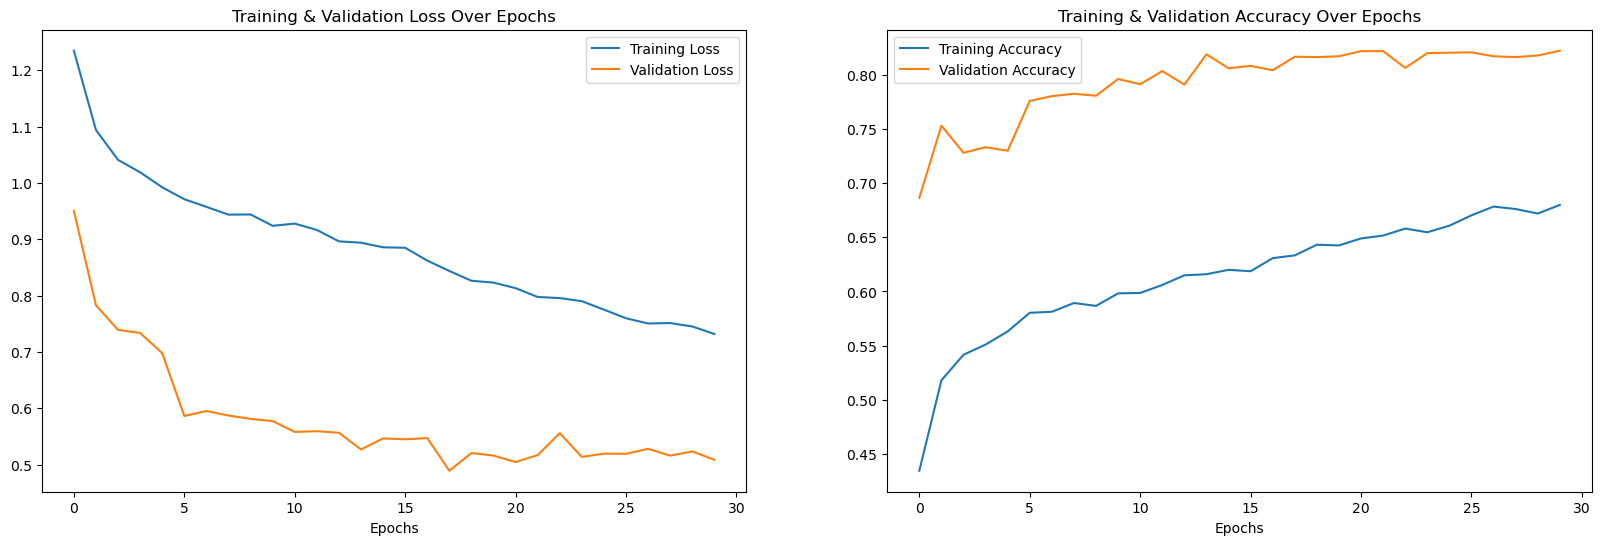

In [12]:
epochs = [i for i in range(30)]
fig, ax = plt.subplots(1,2)
train_accuracy = history.history['accuracy']
train_loss = history.history['loss']
test_accuracy = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs, train_loss, label = 'Training Loss')
ax[0].plot(epochs, test_loss, label = 'Validation Loss')
ax[0].set_title('Training & Validation Loss Over Epochs')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs, train_accuracy, label = 'Training Accuracy')
ax[1].plot(epochs, test_accuracy, label = 'Validation Accuracy')
ax[1].set_title('Training & Validation Accuracy Over Epochs')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [13]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(y_test)

85/85 [==============================] - 4s 51ms/step


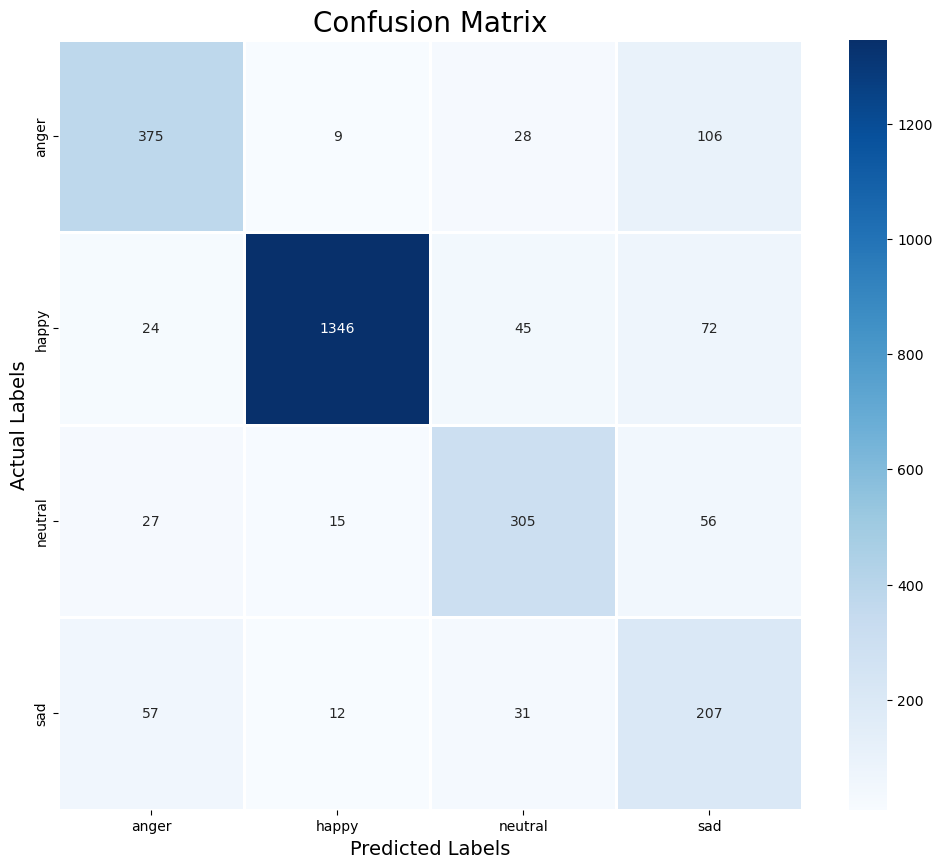

In [14]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [15]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

acs_test = accuracy_score(y_test,y_pred)
ps_test = precision_score(y_test,y_pred, average = "macro")
rs_test = recall_score(y_test,y_pred,  average = "macro")
fs_test = f1_score(y_test,y_pred,  average = "macro")

print("Accuracy Score: ", "{:.2%}".format(acs_test))
print("Precision Score: ", "{:.2%}".format(ps_test))
print("Recall Score: ", "{:.2%}".format(rs_test))
print("F1 Score: ", "{:.2%}".format(fs_test))

Accuracy Score:  82.25%
Precision Score:  74.14%
Recall Score:  76.51%
F1 Score:  74.81%
